_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Names: FILL IN YOUR NAMES HERE

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex.

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys

sys.path.append("../poisson-gpfa/")
sys.path.append("../poisson-gpfa/funs")

import funs.util as util
import funs.engine as engine

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-13 10:51:54CEST

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

sklearn: 1.4.1.post1

numpy     : 1.26.4
seaborn   : 0.13.2
scipy     : 1.12.0
sys       : 3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 14:43:12) [Clang 14.0.6 ]
matplotlib: 3.8.3

Watermark: 2.4.3



In [56]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

In [3]:
?util.dataset

Init signature:
util.dataset(
    trialDur=1000,
    binSize=10,
    drawSameX=False,
    numTrials=20,
    xdim=3,
    ydim=30,
    seed=12,
    dOffset=-1,
    fixTau=False,
    fixedTau=None,
    params=None,
    model='pgpfa',
)
Docstring:     
Dataset containing multiple trials of population spike counts. A dataset is sampled from the
Poisson-GPFA model as described by the equations
    
    x ~ GP(0,K(tau))            - (1)
    y ~ Poisson(exp(Cx+d))      - (2)

Attributes:
  * self.xdim : int, latent dimensionality.
  * self.ydim : int, number of neurons.
  * self.data : list of dictionaries
        The nth element of the list is a dictionary containing the data such that
      - self.data[n]['X'] : numpy array of shape (xdim x T)
            The true latent trajectory of trial n
      - self.data[n]['Y'] : numpy array of shape (ydim x T)
            The spike counts of the population of trial n
  * self.trialDur : int
        The duration of each trial in ms. All trials must ha

In [58]:
?engine.PPGPFAfit

Init signature:
engine.PPGPFAfit(
    experiment,
    initParams=None,
    xdim=2,
    inferenceMethod='laplace',
    maxEMiter=50,
    optimLogLamb=False,
    CdOptimMethod='TNC',
    tauOptimMethod='TNC',
    verbose=False,
    EMmode='Online',
    batchSize=5,
    onlineParamUpdateMethod='diag',
    hessTol=None,
    stepPow=0.75,
    updateCdJointly=True,
    fullyUpdateTau=False,
    extractAllTraj=False,
    extractAllTraj_trueParams=False,
    getPredictionErr=False,
    CdMaxIter=None,
    tauMaxIter=None,
)
Docstring:     
Poisson-GPFA model fit given a neural population spike data. 

Input Attributes:
  * experiment : (util.dataset object), required
    - A dataset object with the following attributes:
        experiment.data     - A list of dictionaries in the following format:
          experiment.data[trial]['Y'] - numpy array of shape (#time bins, # neurons)
        experiment.T        - number of time bins, all trials must have the same length
        experiment.trialDur

In [59]:
?util.initializeParams

Signature: util.initializeParams(xdim, ydim, experiment=None)
Docstring:
Initializes Poisson-GPFA model parameters.

Parameters:
  * xdim       : int, latent dimensionality to fit
  * ydim       : int, number of neurons in the dataset
  * experiment : (optional) If a third optional argument of util.dataset object is given, 
                 the fucntion returns a dictionary of parameters obtained by performing Poisson-
                 PCA Leave this argument empty to initialize randomly.
Returns:
     A dictionary of model parameters.
File:      ~/Desktop/NDS Coding labs/poisson-gpfa/funs/util.py
Type:      function

In [5]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------
n_neurons = 30
n_trials = 100
time = 1000  # ms
bin_size = 50  # ms
# Initialize random number generator
seed = np.random.seed(0)
maxEMiter = 50

d = 0.5


# Generate a random dataset
training_set = util.dataset(
    seed=345533,
    xdim=1,
    ydim=n_neurons,
    numTrials=n_trials,
    trialDur=time,
    binSize=bin_size,
    dOffset=d,
    fixTau=True,
    fixedTau=np.array([0.2]),
    drawSameX=False,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 17.056 Hz.


### Fit the model

In [42]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------

# Initialize parameters using Poisson-PCA
# Initialize parameters using Poisson-PCA
initParams = util.initializeParams(1, n_neurons, training_set)

# fit the model
fitToy = engine.PPGPFAfit(
    experiment=training_set,
    initParams=initParams,
    maxEMiter=maxEMiter,
    batchSize=n_trials,
    verbose=False,
)
# choose sensible parameters and run fit

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                               Online | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
                                               `diag` | Online Param Update Method
                                                  100 | Batch size (trials):
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -508.4210
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [43]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [44]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)

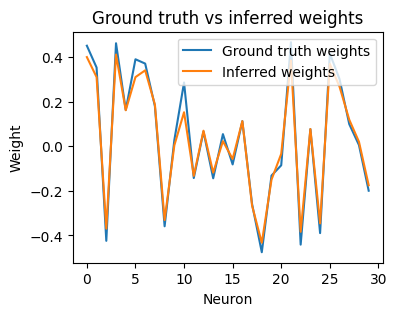

In [57]:
# ----------------------------------------------------
# Plot ground truth and inferred weights `C` (0.5 pts)
# ----------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(training_set.params["C"], label="Ground truth weights")

ax.plot(fitToy.optimParams["C"], label="Inferred weights")
ax.set_title("Ground truth vs inferred weights")
ax.set_xlabel("Neuron")
ax.set_ylabel("Weight")
ax.legend()

# add plot
# consider also plotting the optimal weights as a dotted line for reference

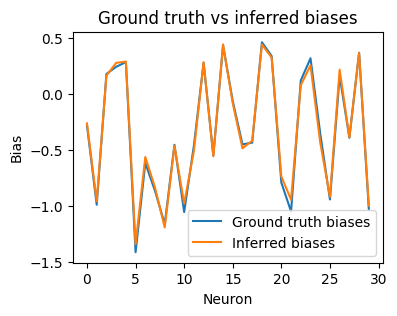

In [32]:
# ---------------------------------------------------
# Plot ground truth and inferred baises `d` (0.5 pts)
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(training_set.params["d"], label="Ground truth biases")
ax.plot(fitToy.optimParams["d"], label="Inferred biases")
ax.set_title("Ground truth vs inferred biases")
ax.set_xlabel("Neuron")
ax.set_ylabel("Bias")
ax.legend()


# add plot
# consider also plotting the optimal weights as a dotted line for reference

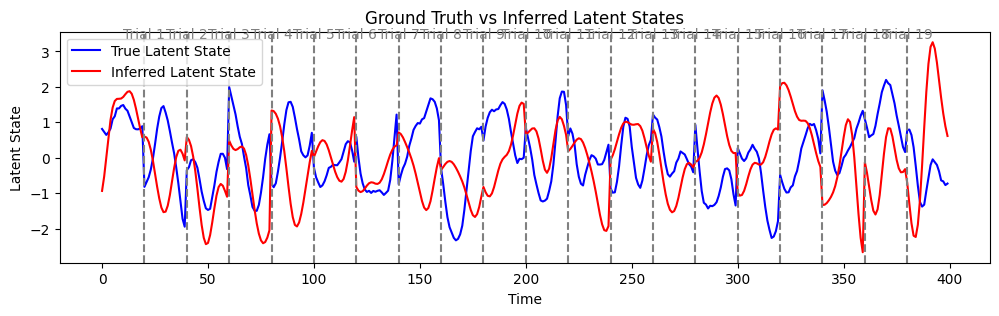

In [48]:
# ------------------------------------------------------
# Plot ground truth and inferred latent states `x` (1pt)
# ------------------------------------------------------


# Calculate the total length of each trial in terms of bins
trials_to_plot = 20
bins_per_trial = time // bin_size
total_bins_to_plot = bins_per_trial * trials_to_plot

# Select the subset of trials to plot (first 10 trials)
start_index = 0
end_index = total_bins_to_plot

# Flatten x_est
x_est = np.squeeze(x_est)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 3))

# Plot the ground truth latent states
ax.plot(x_true[start_index:end_index], label="True Latent State", color="blue")

# Plot the inferred latent states
ax.plot(x_est[start_index:end_index], label="Inferred Latent State", color="red")

# Add vertical lines to separate trials
for i in range(1, trials_to_plot):
    ax.axvline(i * bins_per_trial, color="gray", linestyle="--")
    ax.text(
        i * bins_per_trial,
        ax.get_ylim()[1] * 0.95,
        f"Trial {i}",
        color="gray",
        ha="center",
    )
# Add legend
ax.legend()

# Add labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Latent State")
ax.set_title("Ground Truth vs Inferred Latent States")

# Show the plot
plt.show()


# ax.plot(x_true)

# add plot
# plot only for a subset of trials
# consider seperating each trial by a vertical line

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 2 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [49]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [50]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log-likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$p_\lambda(x_t) = \ldots$

$L(\lambda_k; x_1, ..., x_N) = \ldots$ 

$log(L) = l(\lambda_k; x_1, ..., x_N) = \ldots$

In [54]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# fit the model to the data
xdim = 1  # number of modulators
cross_val = util.crossValidation(
    experiment=data, numTrainingTrials=80, numTestTrials=20, maxXdim=5, maxEMiter=3
)
print(cross_val)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                    3 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:   3 of   3, nPLL: = -407.0379Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

[41376.052358449895, 41199.201933939396, 41016.49976602413, 40131.036288454234, 40654.8358289692]
1
2
3
4
5


Text(0, 0.5, 'SSE of fit')

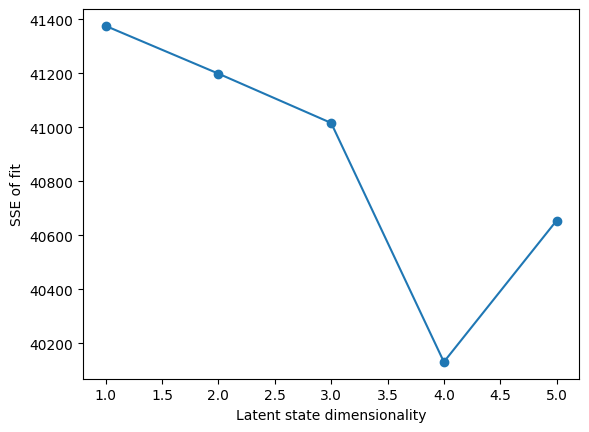

In [90]:
print(cross_val.errs)
x_dim = []
for i in range(len(cross_val.fits)):
    x_dim.append(cross_val.fits[i].xdim)
    print(cross_val.fits[i].xdim)

plt.plot(x_dim, cross_val.errs, "o-")

plt.xlabel("Latent state dimensionality")
plt.ylabel("SSE of fit")

In [91]:
# do the actual cross validation

# Split the data into 80 trials used for training and 20 trials

train, test = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)


latent_dims = [1, 2, 3, 4, 5]
goodness_of_fit = []

print(n_neurons)
# Fit the model to the training data
for latent_dim in latent_dims:
    initParams = util.initializeParams(latent_dim, n_neurons, train)
    fit = engine.PPGPFAfit(
        experiment=train,
        initParams=initParams,
        maxEMiter=maxEMiter,
        batchSize=80,
        verbose=False,
    )
    predGrad, predErr = util.leaveOneOutPrediction(fit.optimParams, train)
    goodness_of_fit.append(predErr)
print(goodness_of_fit)

55
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                               Online | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
                                               `diag` | Online Param Update Method
                                                   80 | Batch size (trials):
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -390.8491Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
          

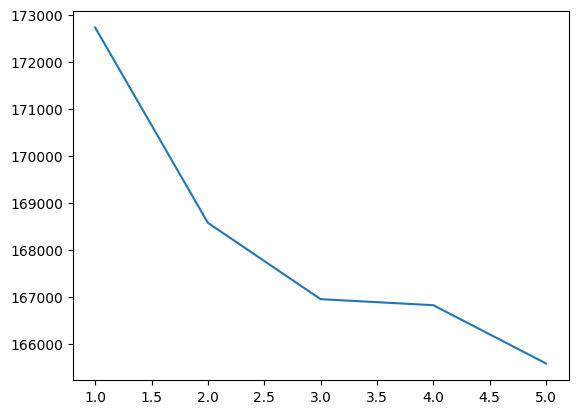

In [92]:
plt.plot(latent_dims, goodness_of_fit)

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above).

In [ ]:
# -----------------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (0.5 + 0.5 pts)
# -----------------------------------------------------------------------------------------

train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)
# compute baseline error
baseline_error = 

In [ ]:
# Your plot here
fig, ax = plt.subplots(figsize=(4, 3))

# plot model error

# plot baseline
ax.axhline(baseline_error, linestyle="--")

## Task 3. Visualization: population rasters and latent state. Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

In [ ]:
from numpy import matlib

# Your plot here
fig, axs = plt.subplots(10, 2, figsize=(14, 14))

ts = np.linspace(0, 2000, 100)
xa = 0.15
xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        x = range(50, 2000, 100)  # assume binsize of 100ms

        # ------------------------
        # plot latent state (1 pt)
        # ------------------------

        # hint: can be plotted on top of the corresponding raster
        
        # sort neurons by weight

        # ----------------------------------
        # plot raster for each neuron (1 pt)
        # ----------------------------------

        if ntrial == 0:
            ax.legend()
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green")
            ax.text(1300, -50, "1sec")
        if ntrial < 2:
            ax.plot(ts, (xs * 40) + data.ydim, "k", color="black")

        ax.set_yticks([])
        ax.set_xticks([])

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [ ]:
# insert your code here

# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    # add your code here
    return c, mu


# --------------------------------------------------------------
# Plot the covariance matrix (1 pt) of
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

# HINT: Think about which type of colormap and ranges are appropriate here. 

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
# add plot to visualize the differences in the covariance matrices